# **Deep Learning | Spring 2023**
## Mini Project
### Yashika Khurana, Raj Oza, Amey Kolhe

Checking GPU availability

In [ ]:
import torch
import numpy as np
import wandb
wandb.login()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pandya-aarav-97 (aarav). Use `wandb login --relogin` to force relogin


CUDA is available!  Training on GPU ...


Data pre-processing and augmentation

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# setting subprocesses, samples per batcg and train-validation split
num_workers = 0
batch_size = 20
valid_size = 0.2

print('==> Preparing data..')
#performing data augmentation- random cropping, random rotation and random flipping(horizontal)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Normalizing test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
data_dir = '/scratch/ap7641/raj/data'
# loading train & test set
train_data = datasets.CIFAR10(data_dir, train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10(data_dir, train=False,
                             download=True, transform=transform_test)

# setting validation data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# using samplers for training and validation data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# using data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# 10 classes in the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


Visualizing the data (with help from ChatGPT)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

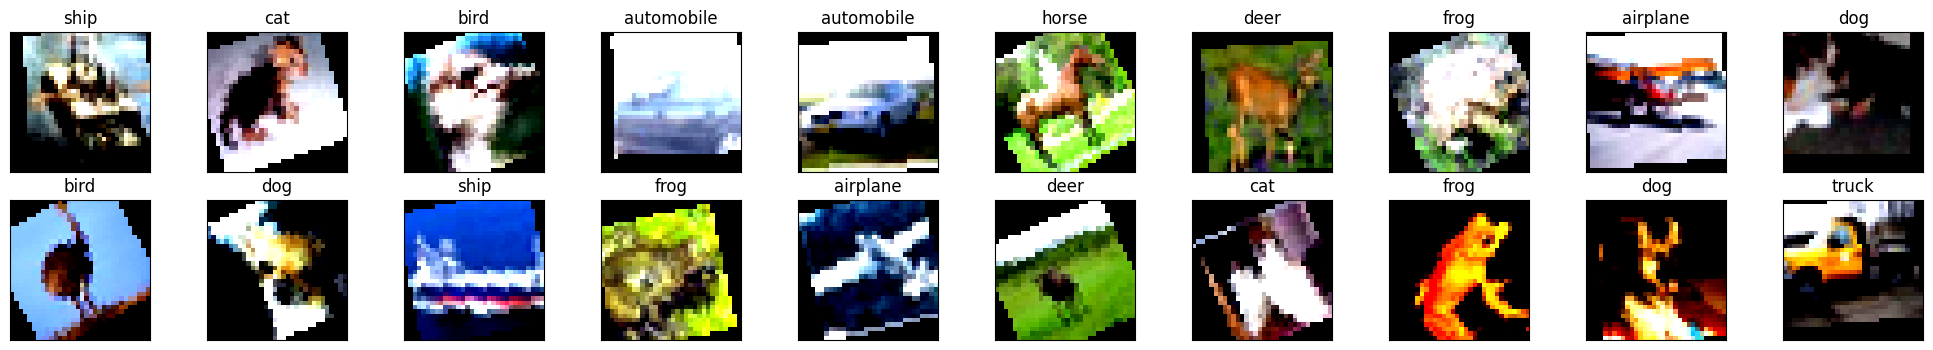

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])        

Defining the Network architecture


In [ ]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
import torch.nn.utils.prune as prune
import torchvision.models as models


class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [1,1,1,1])

#pruning_level = 0.5

# Pruning
#for name, module in model.named_modules():
    #if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        #prune.l1_unstructured(module, name='weight', amount=pruning_level)

# Print the number of parameters 
num_parameters = sum(p.numel() for p in ResNet18.parameters() if p.requires_grad)
print("Number of parameters after pruning: ", num_parameters)


if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

Number of parameters after pruning:  4903242


In [ ]:
# We have not used pruning

In [ ]:
ResNet18 = torch.compile(ResNet18)

Specifying the loss function and optimizer

In [ ]:
import torch.optim as optim
# loss function: categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# optimizer: SGD
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


Training 
(Saving the model when validation loss decreases)

In [ ]:
from tqdm import tqdm
n_epochs = 200
from torch.optim.lr_scheduler import ReduceLROnPlateau
valid_loss_min = np.Inf # track change in validation loss
run = wandb.init(project='raj')
wandb.watch(ResNet18)
scheduler = ReduceLROnPlateau(optimizer, 'min')

for epoch in tqdm(range(1, n_epochs+1)):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0
    

  # training
 
  ResNet18.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GCUDA
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass
    loss.backward()
    # parameter update
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)
        

  # validation
  
  ResNet18.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss})
  # printing stats
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))
  
  scheduler.step(valid_loss)
    
  # saveing model
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(ResNet18.state_dict(), 'ResNet18.pt')
    valid_loss_min = valid_loss
    

  0%|          | 1/200 [00:31<1:44:59, 31.66s/it]

Epoch: 1 	Training Loss: 1.071631 	Validation Loss: 0.932920
Validation loss decreased (inf --> 0.932920).  Saving model ...


  1%|          | 2/200 [01:03<1:44:09, 31.56s/it]

Epoch: 2 	Training Loss: 0.920627 	Validation Loss: 0.858431
Validation loss decreased (0.932920 --> 0.858431).  Saving model ...


  2%|▏         | 3/200 [01:35<1:44:29, 31.82s/it]

Epoch: 3 	Training Loss: 0.821203 	Validation Loss: 0.795759
Validation loss decreased (0.858431 --> 0.795759).  Saving model ...


  2%|▏         | 4/200 [02:06<1:43:39, 31.73s/it]

Epoch: 4 	Training Loss: 0.751828 	Validation Loss: 0.697390
Validation loss decreased (0.795759 --> 0.697390).  Saving model ...


  2%|▎         | 5/200 [02:38<1:42:58, 31.69s/it]

Epoch: 5 	Training Loss: 0.692063 	Validation Loss: 0.649061
Validation loss decreased (0.697390 --> 0.649061).  Saving model ...


  3%|▎         | 6/200 [03:10<1:42:24, 31.67s/it]

Epoch: 6 	Training Loss: 0.643613 	Validation Loss: 0.636840
Validation loss decreased (0.649061 --> 0.636840).  Saving model ...


  4%|▎         | 7/200 [03:42<1:42:07, 31.75s/it]

Epoch: 7 	Training Loss: 0.606571 	Validation Loss: 0.612280
Validation loss decreased (0.636840 --> 0.612280).  Saving model ...


  4%|▍         | 8/200 [04:13<1:41:24, 31.69s/it]

Epoch: 8 	Training Loss: 0.572157 	Validation Loss: 0.571542
Validation loss decreased (0.612280 --> 0.571542).  Saving model ...


  4%|▍         | 9/200 [04:45<1:41:11, 31.79s/it]

Epoch: 9 	Training Loss: 0.540848 	Validation Loss: 0.592279


  5%|▌         | 10/200 [05:17<1:40:34, 31.76s/it]

Epoch: 10 	Training Loss: 0.509803 	Validation Loss: 0.544568
Validation loss decreased (0.571542 --> 0.544568).  Saving model ...


  6%|▌         | 11/200 [05:48<1:39:45, 31.67s/it]

Epoch: 11 	Training Loss: 0.485835 	Validation Loss: 0.537313
Validation loss decreased (0.544568 --> 0.537313).  Saving model ...


  6%|▌         | 12/200 [06:20<1:39:17, 31.69s/it]

Epoch: 12 	Training Loss: 0.461911 	Validation Loss: 0.489336
Validation loss decreased (0.537313 --> 0.489336).  Saving model ...


  6%|▋         | 13/200 [06:52<1:39:11, 31.82s/it]

Epoch: 13 	Training Loss: 0.445859 	Validation Loss: 0.508617


  7%|▋         | 14/200 [07:24<1:38:32, 31.79s/it]

Epoch: 14 	Training Loss: 0.426632 	Validation Loss: 0.461390
Validation loss decreased (0.489336 --> 0.461390).  Saving model ...


  8%|▊         | 15/200 [07:55<1:37:40, 31.68s/it]

Epoch: 15 	Training Loss: 0.409456 	Validation Loss: 0.446871
Validation loss decreased (0.461390 --> 0.446871).  Saving model ...


  8%|▊         | 16/200 [08:27<1:37:21, 31.75s/it]

Epoch: 16 	Training Loss: 0.399990 	Validation Loss: 0.468363


  8%|▊         | 17/200 [08:59<1:36:47, 31.73s/it]

Epoch: 17 	Training Loss: 0.381793 	Validation Loss: 0.425624
Validation loss decreased (0.446871 --> 0.425624).  Saving model ...


  9%|▉         | 18/200 [09:30<1:36:04, 31.67s/it]

Epoch: 18 	Training Loss: 0.372801 	Validation Loss: 0.441381


 10%|▉         | 19/200 [10:02<1:35:26, 31.64s/it]

Epoch: 19 	Training Loss: 0.352129 	Validation Loss: 0.438938


 10%|█         | 20/200 [10:34<1:35:03, 31.68s/it]

Epoch: 20 	Training Loss: 0.346146 	Validation Loss: 0.444357


 10%|█         | 21/200 [11:05<1:34:21, 31.63s/it]

Epoch: 21 	Training Loss: 0.333978 	Validation Loss: 0.442360


 11%|█         | 22/200 [11:37<1:33:42, 31.59s/it]

Epoch: 22 	Training Loss: 0.324657 	Validation Loss: 0.440430


 12%|█▏        | 23/200 [12:08<1:33:09, 31.58s/it]

Epoch: 23 	Training Loss: 0.321183 	Validation Loss: 0.415530
Validation loss decreased (0.425624 --> 0.415530).  Saving model ...


 12%|█▏        | 24/200 [12:40<1:32:29, 31.53s/it]

Epoch: 24 	Training Loss: 0.308580 	Validation Loss: 0.402546
Validation loss decreased (0.415530 --> 0.402546).  Saving model ...


 12%|█▎        | 25/200 [13:12<1:32:11, 31.61s/it]

Epoch: 25 	Training Loss: 0.304119 	Validation Loss: 0.418261


 13%|█▎        | 26/200 [13:43<1:31:27, 31.54s/it]

Epoch: 26 	Training Loss: 0.293978 	Validation Loss: 0.407681


 14%|█▎        | 27/200 [14:14<1:30:58, 31.55s/it]

Epoch: 27 	Training Loss: 0.279951 	Validation Loss: 0.409236


 14%|█▍        | 28/200 [14:46<1:30:36, 31.61s/it]

Epoch: 28 	Training Loss: 0.283399 	Validation Loss: 0.395625
Validation loss decreased (0.402546 --> 0.395625).  Saving model ...


 14%|█▍        | 29/200 [15:18<1:30:14, 31.67s/it]

Epoch: 29 	Training Loss: 0.274399 	Validation Loss: 0.393992
Validation loss decreased (0.395625 --> 0.393992).  Saving model ...


 15%|█▌        | 30/200 [15:50<1:30:01, 31.77s/it]

Epoch: 30 	Training Loss: 0.267002 	Validation Loss: 0.416703


 16%|█▌        | 31/200 [16:22<1:29:30, 31.78s/it]

Epoch: 31 	Training Loss: 0.261521 	Validation Loss: 0.428284


 16%|█▌        | 32/200 [16:53<1:28:44, 31.69s/it]

Epoch: 32 	Training Loss: 0.253654 	Validation Loss: 0.415806


 16%|█▋        | 33/200 [17:25<1:28:02, 31.63s/it]

Epoch: 33 	Training Loss: 0.246891 	Validation Loss: 0.447618


 17%|█▋        | 34/200 [17:57<1:27:50, 31.75s/it]

Epoch: 34 	Training Loss: 0.249423 	Validation Loss: 0.425569


 18%|█▊        | 35/200 [18:29<1:27:47, 31.92s/it]

Epoch: 35 	Training Loss: 0.236541 	Validation Loss: 0.389882
Validation loss decreased (0.393992 --> 0.389882).  Saving model ...


 18%|█▊        | 36/200 [19:01<1:27:13, 31.91s/it]

Epoch: 36 	Training Loss: 0.233109 	Validation Loss: 0.383873
Validation loss decreased (0.389882 --> 0.383873).  Saving model ...


 18%|█▊        | 37/200 [19:33<1:26:34, 31.87s/it]

Epoch: 37 	Training Loss: 0.234276 	Validation Loss: 0.385656


 19%|█▉        | 38/200 [20:04<1:25:48, 31.78s/it]

Epoch: 38 	Training Loss: 0.227096 	Validation Loss: 0.405251


 20%|█▉        | 39/200 [20:36<1:25:25, 31.83s/it]

Epoch: 39 	Training Loss: 0.223295 	Validation Loss: 0.386142


 20%|██        | 40/200 [21:08<1:24:43, 31.77s/it]

Epoch: 40 	Training Loss: 0.213793 	Validation Loss: 0.398975


 20%|██        | 41/200 [21:40<1:24:33, 31.91s/it]

Epoch: 41 	Training Loss: 0.212037 	Validation Loss: 0.387954


 21%|██        | 42/200 [22:16<1:27:03, 33.06s/it]

Epoch: 42 	Training Loss: 0.211890 	Validation Loss: 0.380711
Validation loss decreased (0.383873 --> 0.380711).  Saving model ...


 22%|██▏       | 43/200 [22:56<1:32:01, 35.17s/it]

Epoch: 43 	Training Loss: 0.208185 	Validation Loss: 0.384463


 22%|██▏       | 44/200 [23:27<1:28:03, 33.87s/it]

Epoch: 44 	Training Loss: 0.208749 	Validation Loss: 0.395208


 22%|██▎       | 45/200 [23:58<1:25:32, 33.11s/it]

Epoch: 45 	Training Loss: 0.201204 	Validation Loss: 0.373501
Validation loss decreased (0.380711 --> 0.373501).  Saving model ...


 23%|██▎       | 46/200 [24:30<1:23:50, 32.67s/it]

Epoch: 46 	Training Loss: 0.203917 	Validation Loss: 0.384870


 24%|██▎       | 47/200 [25:06<1:26:05, 33.76s/it]

Epoch: 47 	Training Loss: 0.199103 	Validation Loss: 0.405102


 24%|██▍       | 48/200 [25:49<1:32:46, 36.62s/it]

Epoch: 48 	Training Loss: 0.188714 	Validation Loss: 0.424022


 24%|██▍       | 49/200 [26:33<1:37:09, 38.60s/it]

Epoch: 49 	Training Loss: 0.195633 	Validation Loss: 0.392102


 25%|██▌       | 50/200 [27:17<1:40:48, 40.32s/it]

Epoch: 50 	Training Loss: 0.187713 	Validation Loss: 0.389115


 26%|██▌       | 51/200 [27:50<1:34:46, 38.16s/it]

Epoch: 51 	Training Loss: 0.187995 	Validation Loss: 0.397598


 26%|██▌       | 52/200 [28:22<1:29:23, 36.24s/it]

Epoch: 52 	Training Loss: 0.185393 	Validation Loss: 0.411213


 26%|██▋       | 53/200 [28:53<1:25:18, 34.82s/it]

Epoch: 53 	Training Loss: 0.178762 	Validation Loss: 0.370032
Validation loss decreased (0.373501 --> 0.370032).  Saving model ...


 27%|██▋       | 54/200 [29:25<1:22:33, 33.93s/it]

Epoch: 54 	Training Loss: 0.183319 	Validation Loss: 0.408807


 28%|██▊       | 55/200 [29:57<1:20:39, 33.38s/it]

Epoch: 55 	Training Loss: 0.179687 	Validation Loss: 0.393564


 28%|██▊       | 56/200 [30:29<1:18:58, 32.91s/it]

Epoch: 56 	Training Loss: 0.176617 	Validation Loss: 0.381482


 28%|██▊       | 57/200 [31:01<1:17:24, 32.48s/it]

Epoch: 57 	Training Loss: 0.171411 	Validation Loss: 0.396493


 29%|██▉       | 58/200 [31:32<1:16:12, 32.20s/it]

Epoch: 58 	Training Loss: 0.172006 	Validation Loss: 0.371946


 30%|██▉       | 59/200 [32:04<1:15:09, 31.98s/it]

Epoch: 59 	Training Loss: 0.170938 	Validation Loss: 0.391171


 30%|███       | 60/200 [32:35<1:14:14, 31.82s/it]

Epoch: 60 	Training Loss: 0.167114 	Validation Loss: 0.423573


 30%|███       | 61/200 [33:07<1:13:37, 31.78s/it]

Epoch: 61 	Training Loss: 0.173845 	Validation Loss: 0.422894


 31%|███       | 62/200 [33:38<1:12:57, 31.72s/it]

Epoch: 62 	Training Loss: 0.169006 	Validation Loss: 0.387644


 32%|███▏      | 63/200 [34:10<1:12:18, 31.67s/it]

Epoch: 63 	Training Loss: 0.160560 	Validation Loss: 0.404285


 32%|███▏      | 64/200 [34:42<1:11:49, 31.69s/it]

Epoch: 64 	Training Loss: 0.162964 	Validation Loss: 0.378884


 32%|███▎      | 65/200 [35:14<1:11:30, 31.78s/it]

Epoch: 65 	Training Loss: 0.103231 	Validation Loss: 0.307507
Validation loss decreased (0.370032 --> 0.307507).  Saving model ...


 33%|███▎      | 66/200 [35:45<1:10:45, 31.68s/it]

Epoch: 66 	Training Loss: 0.081194 	Validation Loss: 0.298291
Validation loss decreased (0.307507 --> 0.298291).  Saving model ...


 34%|███▎      | 67/200 [36:16<1:10:00, 31.59s/it]

Epoch: 67 	Training Loss: 0.071394 	Validation Loss: 0.310337


 34%|███▍      | 68/200 [36:48<1:09:30, 31.59s/it]

Epoch: 68 	Training Loss: 0.067917 	Validation Loss: 0.314494


 34%|███▍      | 69/200 [37:20<1:08:54, 31.56s/it]

Epoch: 69 	Training Loss: 0.064445 	Validation Loss: 0.312731


 35%|███▌      | 70/200 [37:51<1:08:36, 31.67s/it]

Epoch: 70 	Training Loss: 0.058974 	Validation Loss: 0.305069


 36%|███▌      | 71/200 [38:24<1:08:27, 31.84s/it]

Epoch: 71 	Training Loss: 0.059428 	Validation Loss: 0.312839


 36%|███▌      | 72/200 [38:56<1:08:05, 31.92s/it]

Epoch: 72 	Training Loss: 0.058991 	Validation Loss: 0.305237


 36%|███▋      | 73/200 [39:28<1:07:27, 31.87s/it]

Epoch: 73 	Training Loss: 0.054952 	Validation Loss: 0.301507


 37%|███▋      | 74/200 [39:59<1:06:49, 31.83s/it]

Epoch: 74 	Training Loss: 0.052565 	Validation Loss: 0.308053


 38%|███▊      | 75/200 [40:31<1:06:12, 31.78s/it]

Epoch: 75 	Training Loss: 0.051704 	Validation Loss: 0.303918


 38%|███▊      | 76/200 [41:03<1:05:48, 31.84s/it]

Epoch: 76 	Training Loss: 0.048748 	Validation Loss: 0.307074


 38%|███▊      | 77/200 [41:34<1:05:04, 31.75s/it]

Epoch: 77 	Training Loss: 0.045816 	Validation Loss: 0.305769


 39%|███▉      | 78/200 [42:06<1:04:21, 31.65s/it]

Epoch: 78 	Training Loss: 0.046097 	Validation Loss: 0.298496


 40%|███▉      | 79/200 [42:38<1:03:56, 31.70s/it]

Epoch: 79 	Training Loss: 0.044849 	Validation Loss: 0.302741


 40%|████      | 80/200 [43:09<1:03:21, 31.68s/it]

Epoch: 80 	Training Loss: 0.044009 	Validation Loss: 0.304614


 40%|████      | 81/200 [43:41<1:02:41, 31.61s/it]

Epoch: 81 	Training Loss: 0.044557 	Validation Loss: 0.298410


 41%|████      | 82/200 [44:12<1:02:01, 31.54s/it]

Epoch: 82 	Training Loss: 0.042916 	Validation Loss: 0.287534
Validation loss decreased (0.298291 --> 0.287534).  Saving model ...


 42%|████▏     | 83/200 [44:44<1:01:34, 31.58s/it]

Epoch: 83 	Training Loss: 0.043051 	Validation Loss: 0.295102


 42%|████▏     | 84/200 [45:15<1:00:56, 31.52s/it]

Epoch: 84 	Training Loss: 0.043557 	Validation Loss: 0.291370


 42%|████▎     | 85/200 [45:47<1:00:22, 31.50s/it]

Epoch: 85 	Training Loss: 0.042985 	Validation Loss: 0.313286


 43%|████▎     | 86/200 [46:18<59:54, 31.53s/it]  

Epoch: 86 	Training Loss: 0.040387 	Validation Loss: 0.292453


 44%|████▎     | 87/200 [46:50<59:19, 31.50s/it]

Epoch: 87 	Training Loss: 0.044872 	Validation Loss: 0.301074


 44%|████▍     | 88/200 [47:22<59:00, 31.61s/it]

Epoch: 88 	Training Loss: 0.040531 	Validation Loss: 0.313452


 44%|████▍     | 89/200 [47:53<58:21, 31.55s/it]

Epoch: 89 	Training Loss: 0.041652 	Validation Loss: 0.297305


 45%|████▌     | 90/200 [48:25<57:49, 31.54s/it]

Epoch: 90 	Training Loss: 0.043267 	Validation Loss: 0.298543


 46%|████▌     | 91/200 [48:56<57:15, 31.51s/it]

Epoch: 91 	Training Loss: 0.039895 	Validation Loss: 0.292732


 46%|████▌     | 92/200 [49:28<56:56, 31.64s/it]

Epoch: 92 	Training Loss: 0.042529 	Validation Loss: 0.298803


 46%|████▋     | 93/200 [50:00<56:48, 31.86s/it]

Epoch: 93 	Training Loss: 0.040898 	Validation Loss: 0.309732


 47%|████▋     | 94/200 [50:32<56:07, 31.77s/it]

Epoch: 94 	Training Loss: 0.039742 	Validation Loss: 0.302842


Loading the best model

In [ ]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))

<All keys matched successfully>

In [ ]:
ResNet18

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1),

Testing the model

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

ResNet18.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU 
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass
  output = ResNet18(data)
  # calculating batch loss
  loss = criterion(output, target)
  # updating test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)    
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculating test accuracy
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.323291

Test Accuracy of airplane: 92% (921/1000)
Test Accuracy of automobile: 95% (957/1000)
Test Accuracy of  bird: 86% (869/1000)
Test Accuracy of   cat: 82% (825/1000)
Test Accuracy of  deer: 92% (927/1000)
Test Accuracy of   dog: 86% (863/1000)
Test Accuracy of  frog: 94% (946/1000)
Test Accuracy of horse: 91% (918/1000)
Test Accuracy of  ship: 95% (956/1000)
Test Accuracy of truck: 93% (937/1000)

Test Accuracy (Overall): 91% (9119/10000)
